This is a working notebook for exploring applying the SVM model developed for the koumassi_focus aoi in Abidjan, Ivory Coast, to the flooded image of Beira, Mozambique in March 2019. For full WV-2 images, it is recommended to use hte GBDX platform to apply the model to smaller image windows which can be mosaiced back together.  

Inputs to model include combination of index raw values for:
"Dark" parameter, MBI, MSI, NDVI, NDWI0, NDWI1, NDWI2, NDWIcoastal-MSI, NDWIgreen-MSI
These index values are calculated using the notebook "final_calculating_water_shadow_indices"

The dark parameter is the sum of the red_edge, nir1 and nir2 bands. 

In [24]:
# Import necessary packages
import os
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import geopandas as gpd
import rasterio as rio
import earthpy as et
import earthpy.spatial as es

In [25]:
# For windows users
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

In [42]:
# Define AOI and paths
aoi = 'beira_ps'
band_path = '..\\data\\'+aoi+"\\"
raster_outputs_path = os.path.join(band_path, "outputs\\raster_files\\")

raw_list = glob(raster_outputs_path+"\\"+"*raw*")
raw_list.sort()
# raw_list_mod = raw_list.copy()
# raw_list_mod.remove('..\\data\\beira_ps\\outputs\\raster_files\\raw_ndwi_green_msi.tif')
# raw_list_mod.remove('..\\data\\beira_ps\\outputs\\raster_files\\raw_ndwi_coastal_msi.tif')

all_bands_path = os.path.join(raster_outputs_path + aoi+"_all_bands.tif")

svm_clf_path = "C:\\Users\\katy\\git\\flood-detection\\data\\koumassi_focus_ps\\outputs\\svm\\"
svm_additional_pts_clf_path = "C:\\Users\\katy\\git\\flood-detection\\data\\combined\\"
svm_outputs_path = os.path.join(band_path, "outputs\\svm\\")
try:
    os.makedirs(svm_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")

band_path directory already exists!


In [34]:
# Get meta data for writing out SVM result
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
files_out_meta['count']=1

# Developing map based on trained svm model

In [43]:
# Load saved SVM classifer
# loaded_clf = pickle.load(open(svm_clf_path+'pickle_svm_final_with_ndvi', 'rb'))
loaded_clf = pickle.load(open(svm_additional_pts_clf_path+'pickle_combined_svm_424', 'rb'))

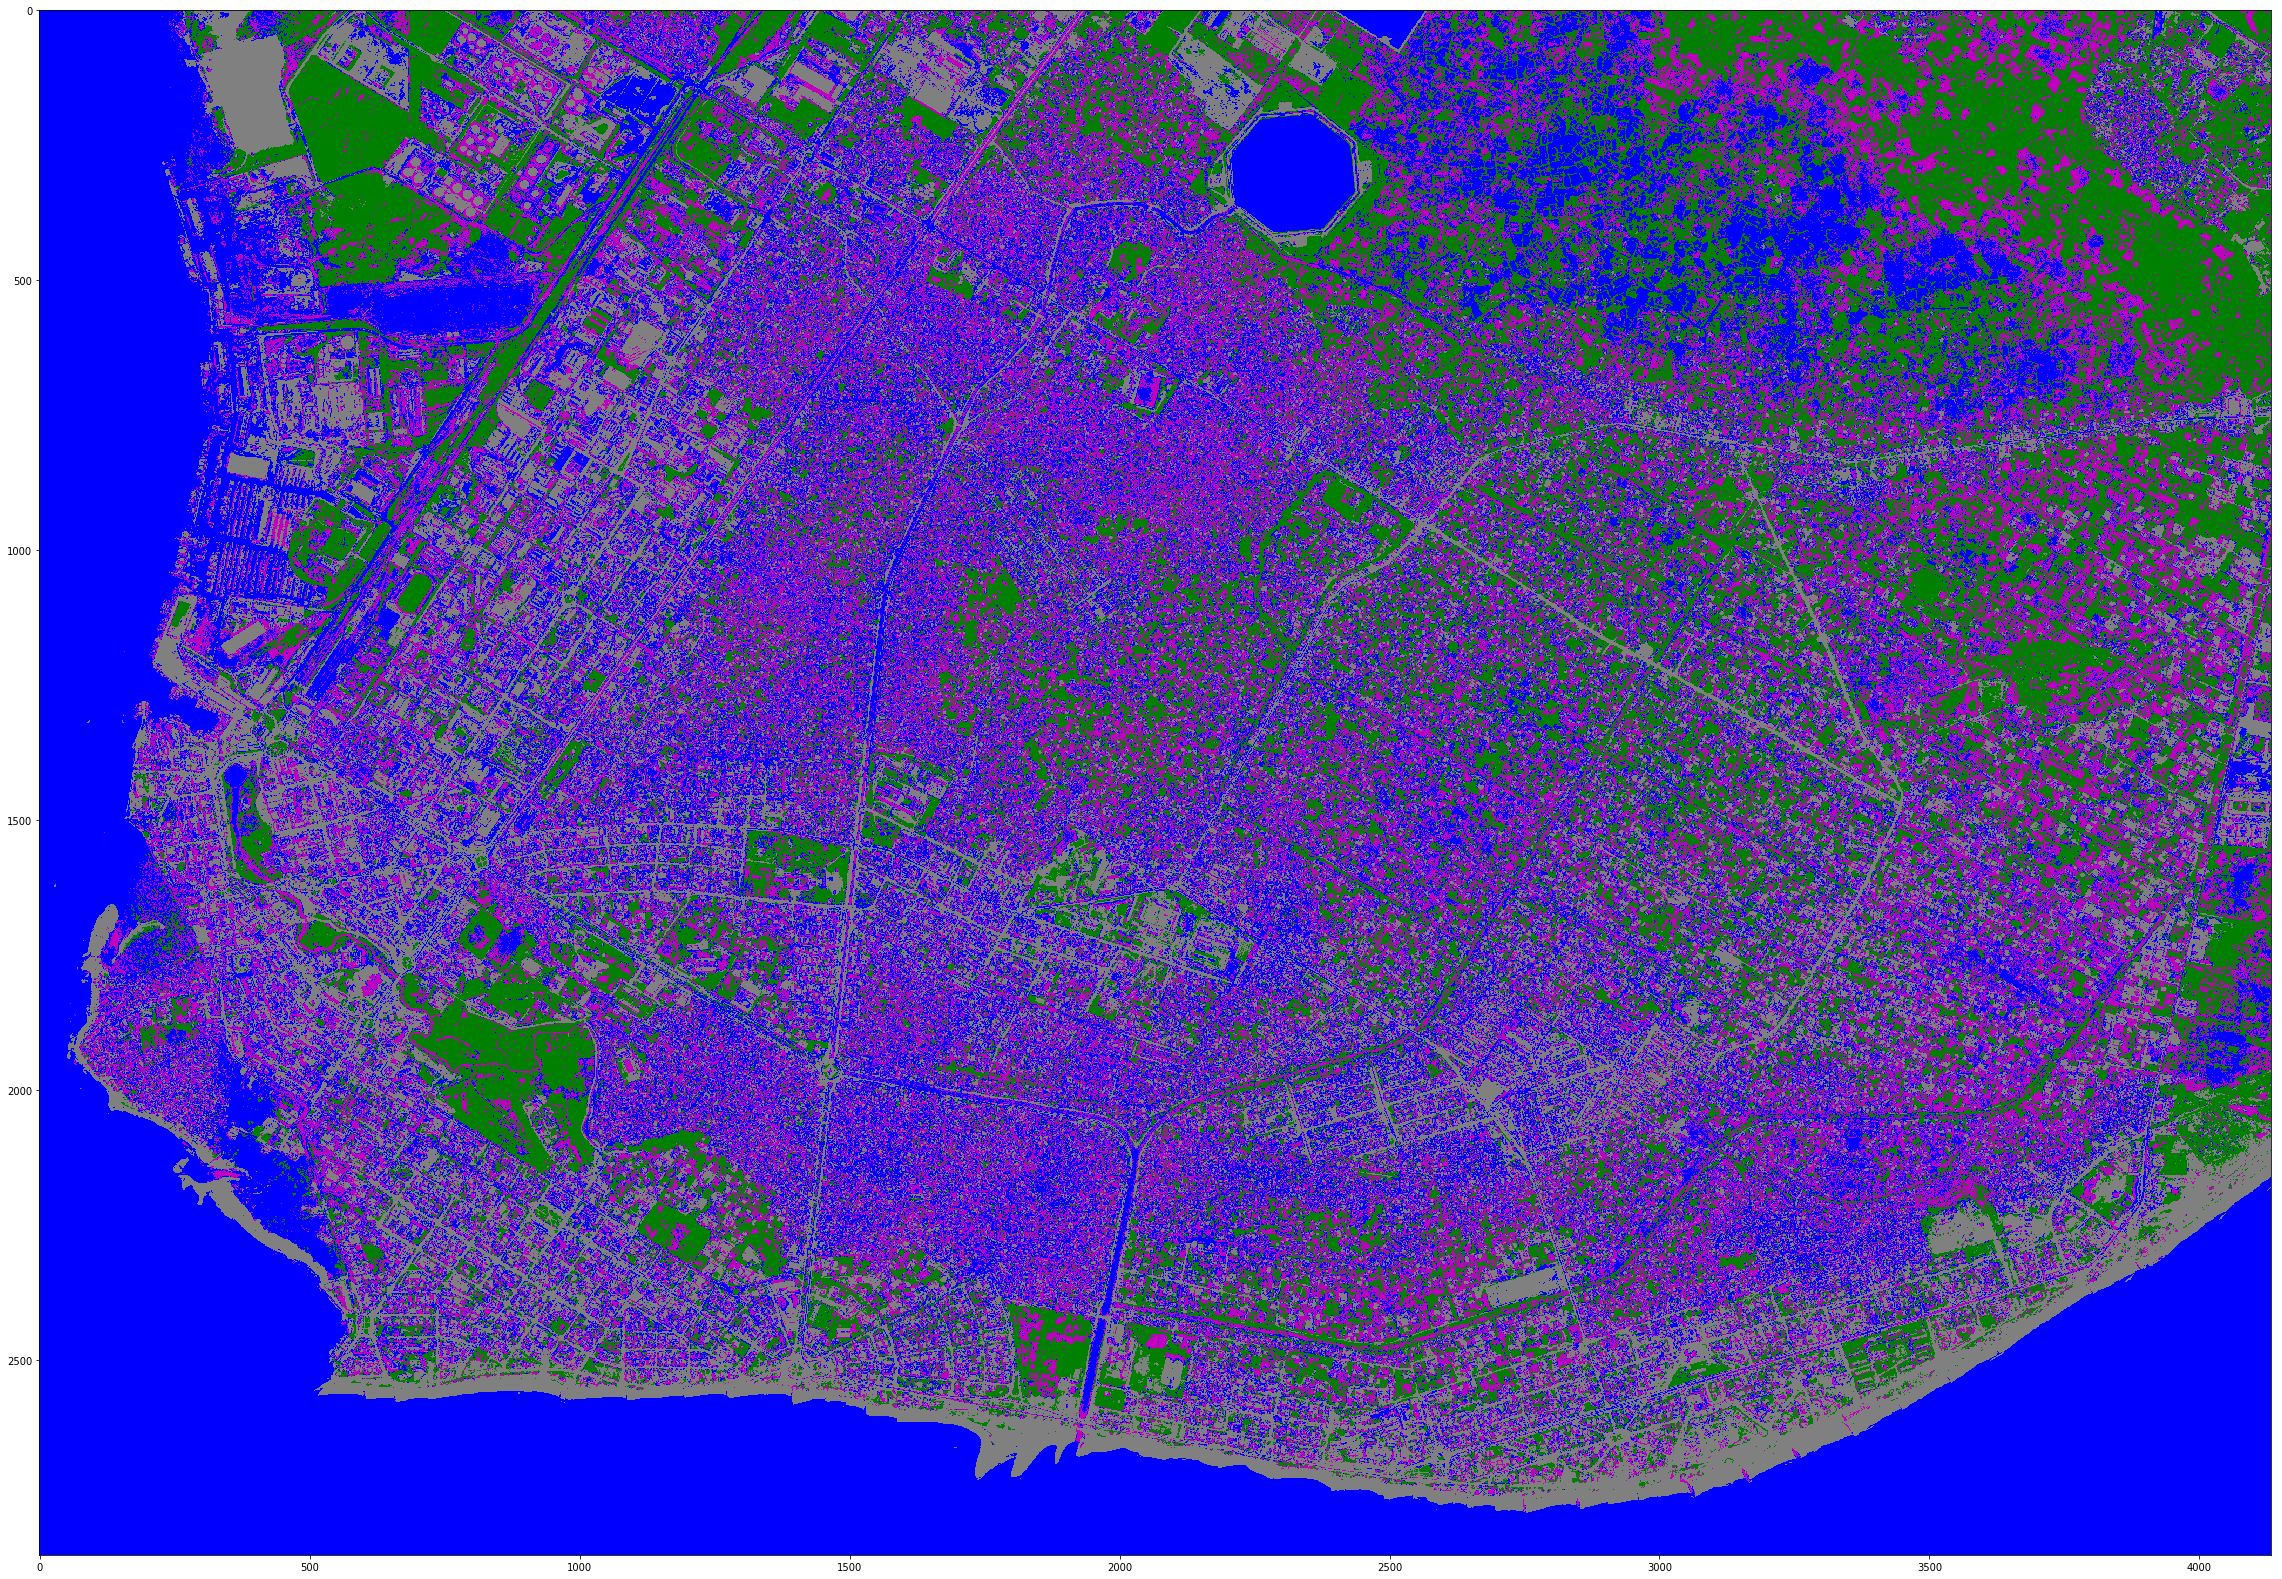

In [45]:
# Apply saved classifer to new image 
index_stack, meta = es.stack(raw_list)
index_im = np.rollaxis(index_stack, 0, 3)
X_index = index_im.reshape(-1,8)
predictedClass = loaded_clf.predict(X_index)

# Plot result
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(index_im.shape[:2])
cmap = ListedColormap(['m','blue','green','grey'])
im = ax.imshow(pred_data,cmap=cmap)
plt.show()

# Write out map tif
with rio.open(svm_outputs_path+'SVM_map_updated.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data.astype('float32'),1)

# Random forest

In [7]:
# clf_random_forest = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=10)

In [48]:
# Load saved RF classifier
loaded_rf_clf = pickle.load(open(svm_additional_pts_clf_path+'pickle_combined_RF_424', 'rb'))

# Plot random forest

[1 2 3 4]


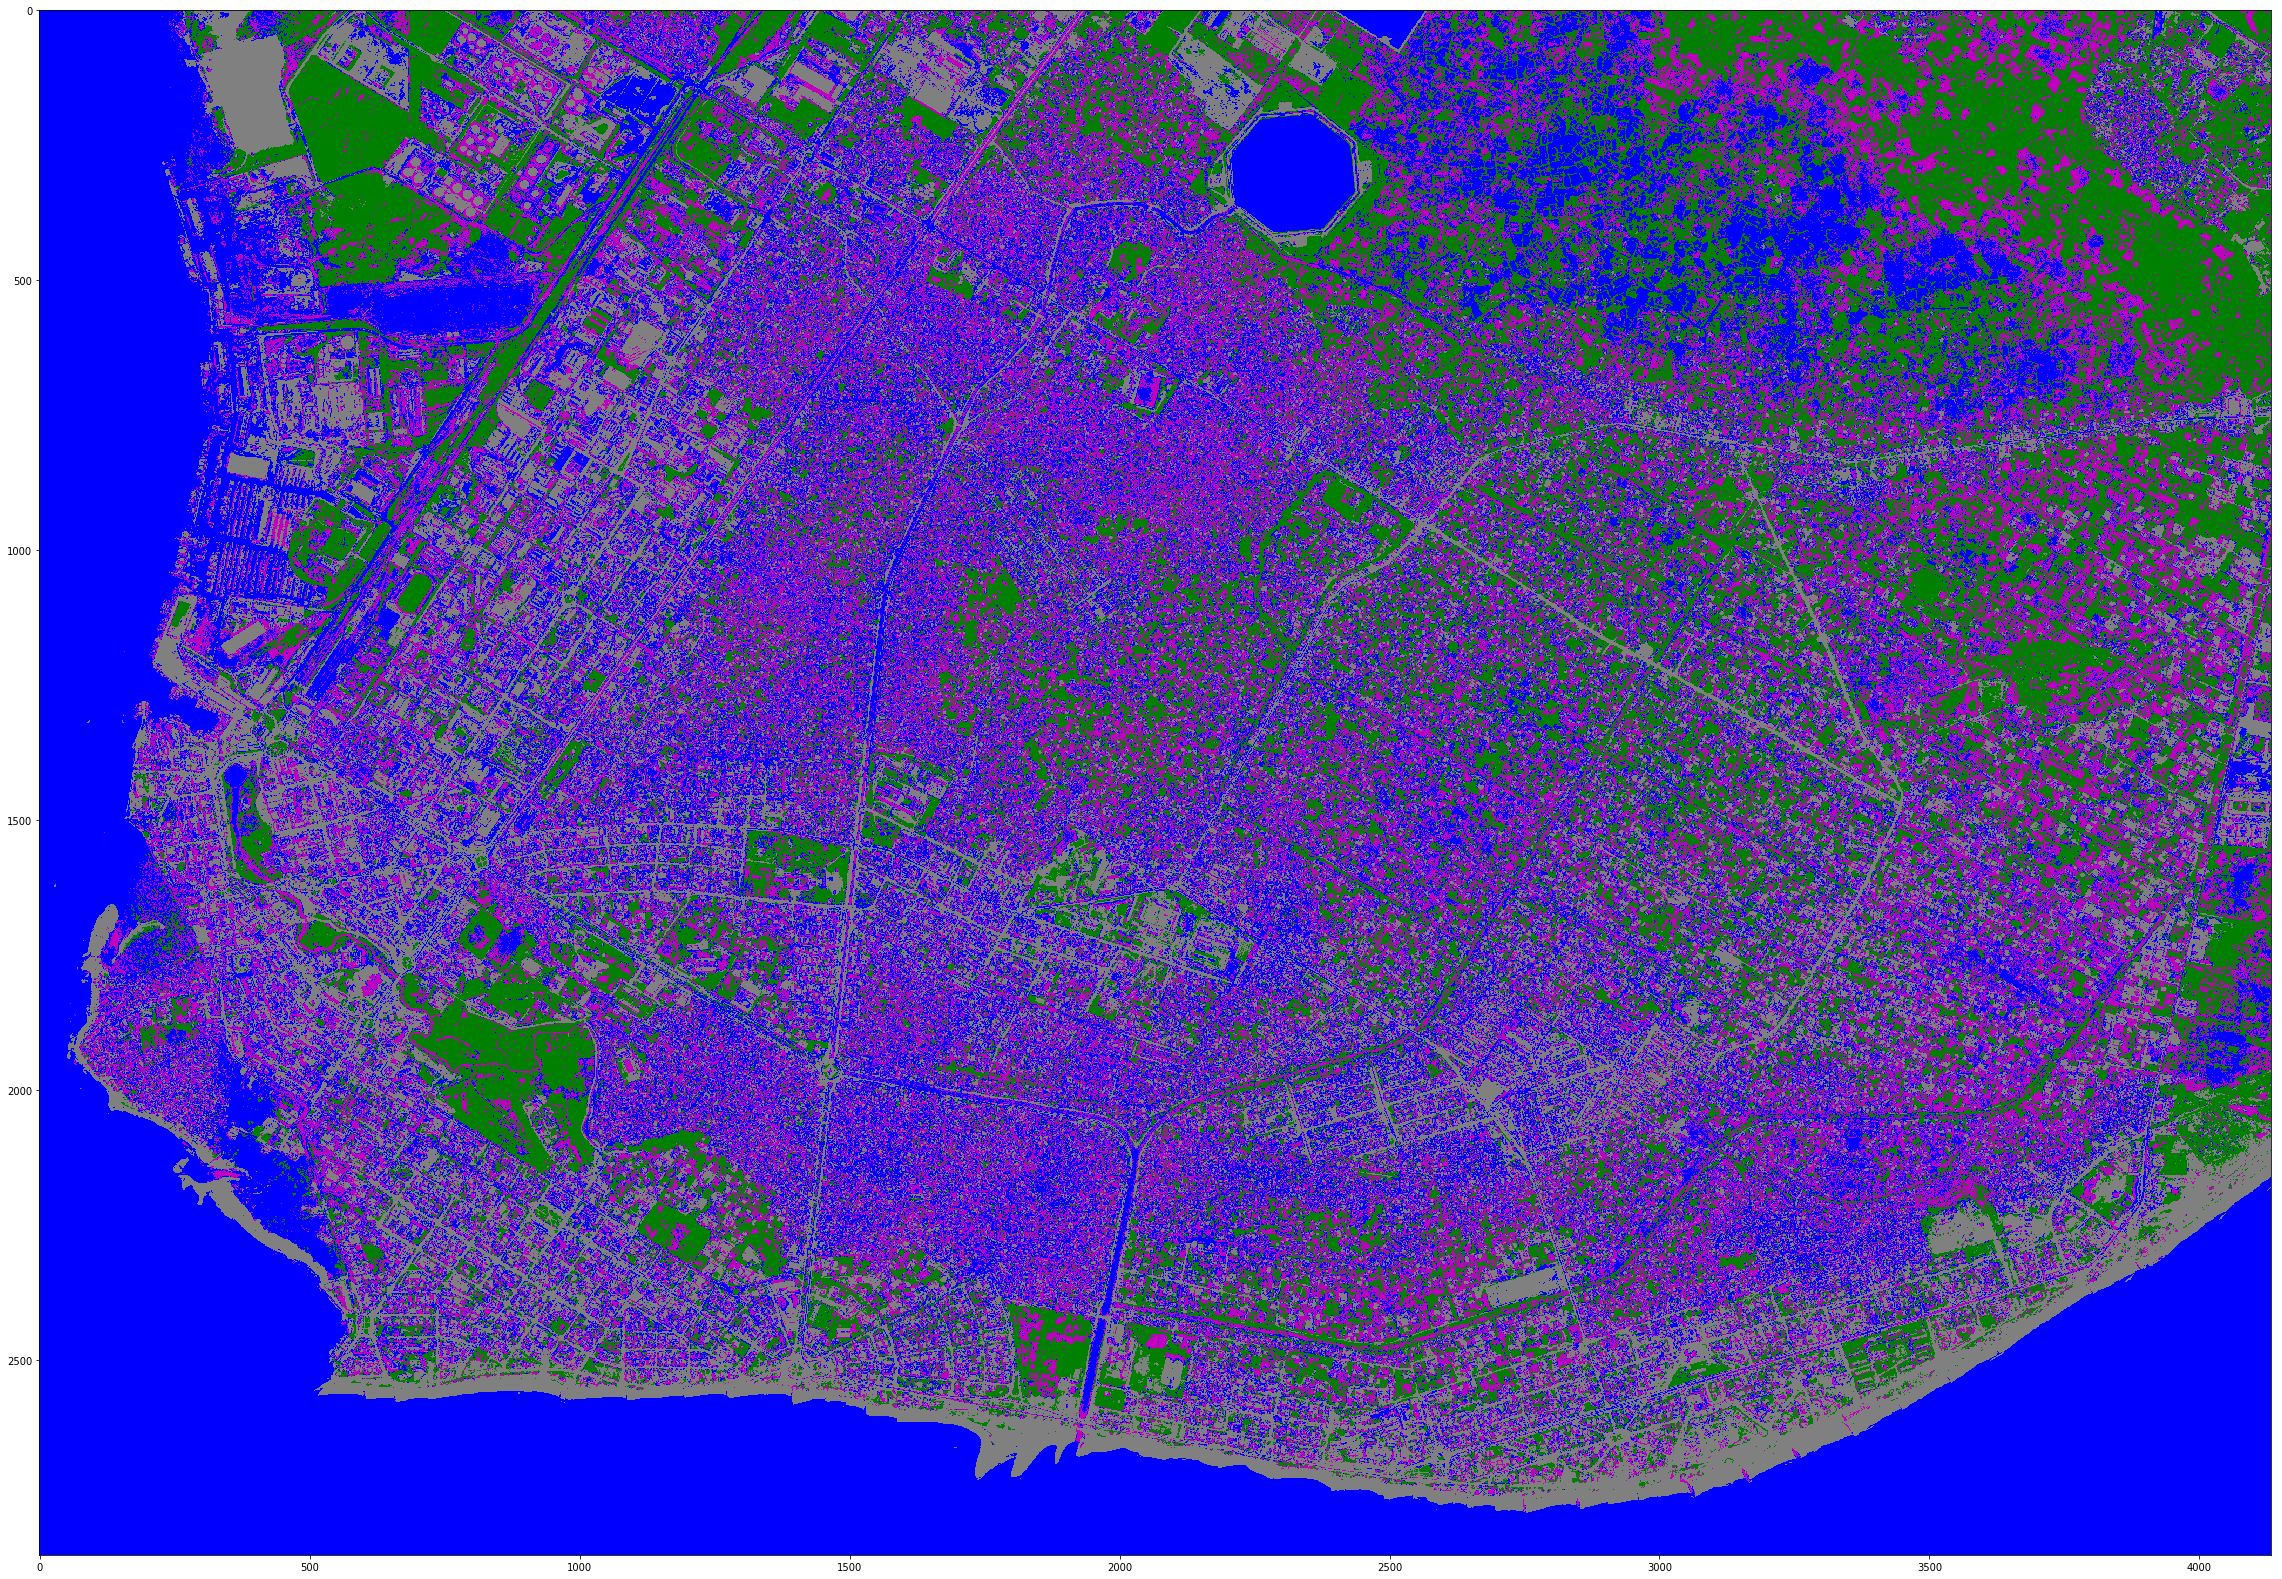

In [49]:
# Apply RF model and plot result
index_stack, meta = es.stack(raw_list)
index_im = np.rollaxis(index_stack, 0, 3)
X_index = index_im.reshape(-1,8)
predictedClass_random_forest = loaded_rf_clf.predict(X_index)

from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data_random_forest = predictedClass.reshape(index_im.shape[:2])
cmap = ListedColormap(['m','blue','green','grey'])
im = ax.imshow(pred_data_random_forest,cmap=cmap)
print(np.unique(pred_data))
plt.show()

# Write out map tif
with rio.open(svm_outputs_path+'random_forest_map_updated.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_random_forest.astype('float32'),1)